In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
root = ET.parse('May_the_wind_be_ever_in_your_favor.gpx').getroot()

trk = root[1]
seg = trk[2]
point = seg[10]

frame = {}
frame['lat'] =  [float(x.get('lat')) for x in seg]
frame['lon'] =  [float(x.get('lon')) for x in seg]
frame['ele'] =  [float(x[0].text) for x in seg]
frame['time'] =  [datetime.strptime(x[1].text, '%Y-%m-%dT%H:%M:%SZ') for x in seg]

df = pd.DataFrame(frame)
df.head()

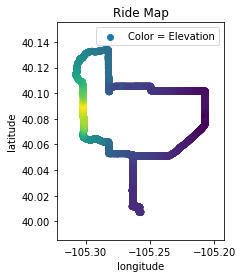

In [7]:
plt.scatter(df.lon,df.lat,c=df.ele)
plt.title('Ride Map')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(['Color = Elevation'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

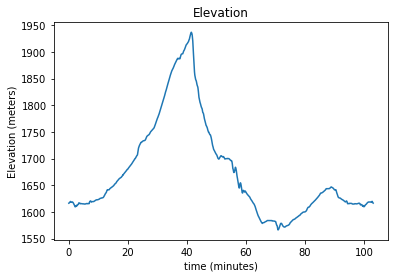

In [5]:
plt.plot((df.time-df.time[0])/np.timedelta64(1, 'm'),df.ele)
plt.title('Elevation')
plt.xlabel('time (minutes)')
plt.ylabel('Elevation (meters)')
plt.show()

# Function Definitions

In [8]:
def to_cartesian(Lat, Long,ele): # Uses kilometers
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    
    earth_radius = 6371 # km
    radius = earth_radius + (ele/1000)
    x_pos = radius*np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = radius*np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = radius*np.sin(Lat)
    
    pos = pd.concat([x_pos,y_pos,z_pos],axis=1)
    return [np.array(x) for x in pos.values]

def distance(p1,p2):
    if p1 is None or p2 is None:
        return None
    return 1000*sum((p2-p1)**2)**.5 # Converts kilometers to meters

# Data definitions

In [9]:
df['cart'] = to_cartesian(df.lat,df.lon, df.ele)

prev_point = None
dists = []
for point in df.cart:
    dists.append(distance(prev_point, point))
    prev_point = point
    
df['delta_dist'] = dists
df['delta_time'] = df.time.diff() / np.timedelta64(1, 's')
df['speed'] = df.delta_dist / df.delta_time
df['delta_ele'] = df.ele.diff()

In [10]:
df.head()

,lat,lon,ele,time,cart,delta_dist,delta_time,speed,delta_ele
0,40.007087,-105.257127,1616.3,2019-09-09 18:19:32,"[-4709.160720306854, -1284.4939018138944, 4096...",NaN,NaN,NaN,NaN
1,40.007134,-105.257164,1616.5,2019-09-09 18:19:38,"[-4709.156796396759, -1284.4960988057585, 4096...",6.107587,6.0,1.017931,0.2
2,40.007153,-105.257215,1616.7,2019-09-09 18:19:40,"[-4709.154490153, -1284.4999733128654, 4096.84...",4.835641,2.0,2.417820,0.2
3,40.007172,-105.257260,1616.8,2019-09-09 18:19:41,"[-4709.152244521696, -1284.5033345188426, 4096...",4.378687,1.0,4.378687,0.1
4,40.007162,-105.257336,1617.0,2019-09-09 18:19:43,"[-4709.151378313914, -1284.5098094521065, 4096...",6.572543,2.0,3.286271,0.2


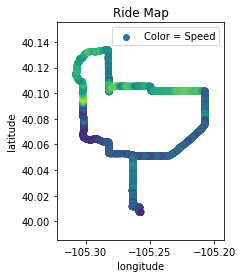

In [20]:
plt.scatter(df.lon,df.lat,c=df.speed)
plt.title('Ride Map')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(['Color = Speed'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

When calculating air resistance, [Cycling Power Labs](https://www.cyclingpowerlab.com/CyclingAerodynamics.aspx) suggests the CdA = 0.4. This accounts for air resistance and frontal area of the average rider on the hoods.

In [12]:
m = 76 # Bodyweight + bike weight
g = 9.8 # Gravity
ele_min = df.ele.min()

# Internal energy should remain constant unless pushed forward by pedaling or backward by wind/rolling resistance
df['energy'] = m*g*(df.ele-ele_min)+.5*m*(df.speed**2) # internal energy = mgh + .5mv^2

drag_constant = 0.4 *.84 # .84 accounts for less dense air at elevation
# Force of air resistance = .5*CdA * v^2
# Power of air resistance = F(Air Res) * dist / time = F * speed
air_resistance = .5 * drag_constant * df.speed**2 * df.speed

rolling_constant = 0.004
# Force of rolling resistance = Coef_rr * m * g
# Power of rolling resistance = Coef_rr * m * g * v
rolling_resistance = rolling_constant * m * g * df.speed

# Sum internal work plus friction loss
df['power'] = (df.energy.diff()/df.delta_time) + air_resistance + rolling_resistance

## The raw data is noisy

Text(0, 0.5, 'Watts')

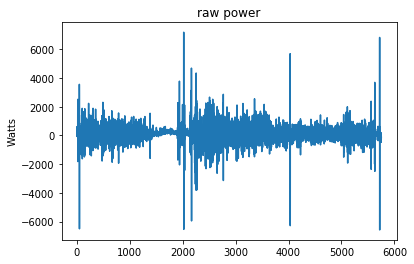

In [13]:
plt.plot(df.power)
plt.title("raw power")
plt.ylabel('Watts')

## Instead, use a rolling average over a small time to get meaningful results

Average power: 141.0911868162169 watts
Average rolling resistance: 22.76264811897444 watts
Average air resistance: 119.43699242280789 watts


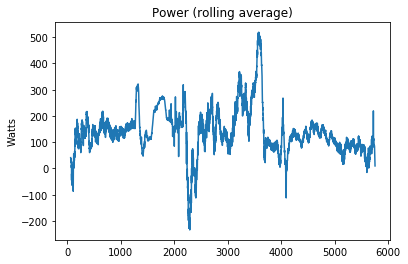

In [14]:
rolling_power = df.power.rolling(60).mean() # ~60s rolling average. Though, not ALL points are 1s apart, just most.
avg_power = rolling_power[rolling_power > 0].sum()/len(rolling_power) # Find average power where power is positive. Negative power is braking

print("Average power: {} watts".format(avg_power))
print("Average rolling resistance: {} watts".format(rolling_resistance.mean()))
print("Average air resistance: {} watts".format(air_resistance.mean()))
plt.plot(rolling_power)

plt.title('Power (rolling average)')
plt.ylabel('Watts')
plt.show()

# Power Zones

Text(0.5, 0, 'Power (watts)')

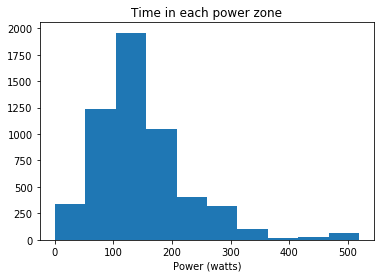

In [24]:
plt.hist(rolling_power[rolling_power > 0]) # Power < 0 is braking
plt.title('Time in each power zone')
plt.xlabel('Power (watts)')

# Calories Burned

In [16]:
seconds = (df.time.max()-df.time.min())/np.timedelta64(1, 's')
joules = avg_power * seconds
Kcal = joules/4184
Kcal = Kcal/.25 # Assume the human body is 25% efficient
print("Calories burned: {} Kcal".format(Kcal))

Calories burned: 834.812003064595 Kcal


# Hill Power

In [17]:
hill_power = df.power[df.delta_ele > 0].mean()
print('Power on hills only: {} watts'.format(hill_power))

Power on hills only: 193.18748248046012 watts


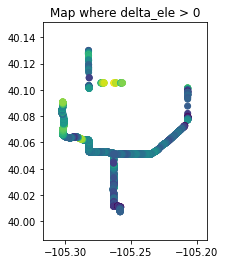

In [47]:
hill = df[df.delta_ele>0]
plt.scatter(hill.lon,hill.lat,c=df.power.rolling(60).mean()[df.delta_ele>0])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Map where delta_ele > 0')
plt.show()

# Segment Graphs

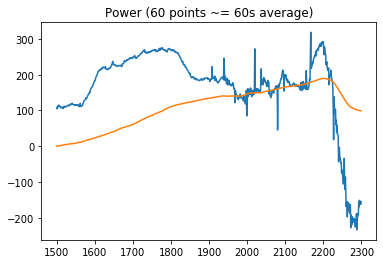

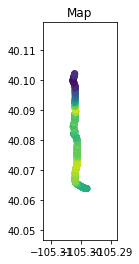

In [46]:
start = 1500
frame = 800
plt.plot(rolling_power[start:start+frame])
plt.plot(df.ele[start:start+frame] - df.ele[start])
plt.title('Power (60 points ~= 60s average)')

fig = plt.figure()
plt.scatter(df.lon[start:start+frame],df.lat[start:start+frame], c=df.power.rolling(60).mean()[start:start+frame])
plt.title('Map')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()